In [76]:
import numpy as np
from pycss.utils import *
from pycss.subset_selection import *
from pycss.CSS import *
import warnings
from tqdm.notebook import tqdm as tqdm_notebook
from matplotlib import pyplot as plt
import itertools
from notebook_utils.data_generation import *

In [77]:
p = 20
k = 5
n=200
B=500
rho = 0.5
#C_chol = scipy.linalg.block_diag(get_equicorrelated_chol(4, rho, diag=1), 
#                        get_equicorrelated_chol(4, rho, diag=1),
#                        get_equicorrelated_chol(4, rho, diag=1),
#                        get_equicorrelated_chol(4, rho, diag=1),
#                        get_equicorrelated_chol(4, rho, diag=1))
#C = C_chol @ C_chol.T

C, C_chol = np.eye(k), np.eye(k)

#W = get_block_W(p, k, num_blocks=4, block_size=8, overlap=4)

np.random.seed(0)
#W *= np.random.choice(np.array([-1, 1]), W.shape)
W = np.random.normal(0, 1, (p-k, k))
W = W/np.linalg.norm(W, axis=1)[:, np.newaxis]



#D = np.concatenate([np.arange(1, 7) for i in range(5)] )
D = np.ones(p-k)

In [37]:
quantiles

[0.337938199689054,
 0.17686002298914782,
 0.06011904518300959,
 0.028660589323037167,
 0.024313989980017214,
 0.0002042670144905001,
 3.635617346509079e-06,
 0.0,
 0.0]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

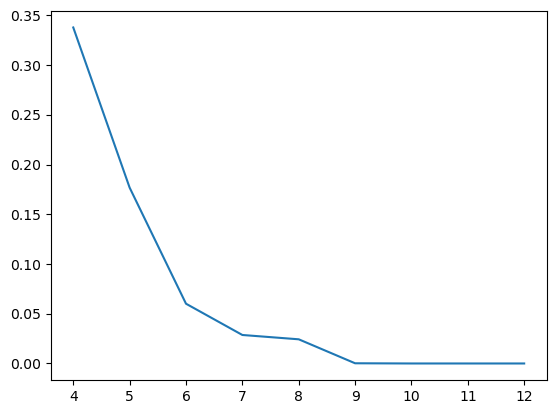

In [36]:
q = 0.8
Sigma_hats = generate_gaussian_PCSS_sample_cov(n, C_chol, W, D=D, B=B)
quantiles = []
search = []
for i in tqdm_notebook(range(k, p + 1)):
    dist = []
    for b in  tqdm_notebook(range(B)):
        S, reject = exhaustive_subset_factor_selection(Sigma_hats[i, :, :], i, cutoff=-np.inf, show_progress=False)
        dist.append(compute_test_stat(Sigma_hats[i, :, :], S))
    quantiles.append(np.quantile(dist, q))
        
plt.plot(range(k, p+1), quantiles)

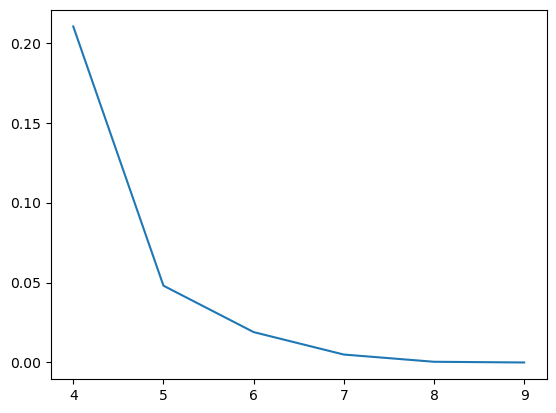

In [26]:
plt.plot(range(k, p), quantiles)

In [40]:
def compute_test_stat(Sigma, S):
    p = Sigma.shape[0]
    Sigma_R = regress_off(Sigma, S)
    S_comp = complement(p, S)
    test_stat = np.sum(np.log(np.diag(Sigma_R)[S_comp])) - np.linalg.slogdet(Sigma_R[S_comp, :][:, S_comp])[1]
    return test_stat

  0%|          | 0/20 [00:00<?, ?it/s]

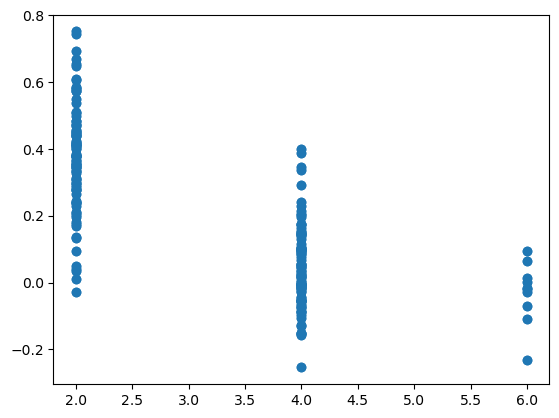

In [11]:
B = 50
add = 3
choose_from = np.arange(k, p)
sym_diffs = []
corrs = []

Sigma_hats = generate_gaussian_PCSS_sample_cov(n, C_chol, W, D=D, B=B)
for to_add_one in tqdm_notebook(list(itertools.combinations(choose_from, add))):
    for to_add_two in list(itertools.combinations(choose_from, add)):
        if set(to_add_one) != set(to_add_two):
            sym_diffs.append(len(set(to_add_one).symmetric_difference(set(to_add_two))))
            S1 = np.concatenate([np.arange(k), np.array(to_add_one)])
            S2 = np.concatenate([np.arange(k), np.array(to_add_two)])
            first = [compute_test_stat(Sigma_hats[i, :, :], S1) for i in range(B)]
            second = [compute_test_stat(Sigma_hats[i, :, :], S2) for i in range(B)]
            corrs.append(np.corrcoef(first, second)[0][1])
plt.scatter(sym_diffs, corrs)

In [69]:
corrs

[]

In [74]:
B=1000
S1 = np.concatenate([np.arange(5), np.array([10, 7])])
S2= np.concatenate([np.arange(5), np.array([18, 19])])
S3 = np.concatenate([np.arange(5), np.array([14, 13, 8])])
S4 = np.concatenate([np.arange(5), np.array([11, 13, 8])])

Sigma_hats = generate_gaussian_PCSS_sample_cov(n, C_chol, W, D=D, B=B)
first = [compute_test_stat(Sigma_hats[i, :, :], S1) for i in range(B)]
second = [compute_test_stat(Sigma_hats[i, :, :], S2) for i in range(B)]
third = [compute_test_stat(Sigma_hats[i, :, :], S3) for i in range(B)]
fourth = [compute_test_stat(Sigma_hats[i, :, :], S4) for i in range(B)]

In [75]:
print(np.corrcoef(first, second))
print(np.corrcoef(third, fourth))


[[1.        0.7548593]
 [0.7548593 1.       ]]
[[1.         0.85038341]
 [0.85038341 1.        ]]


In [5]:


X = np.random.normal(0, 1, (400, 100))


In [6]:
_, Sig = get_moments(X)
Sig = Sig
S1, reject = swapping_subset_factor_selection(Sigma=Sig,
                                     k=20,
                                     cutoff=-np.inf,
                                     max_iter=100,
                                     num_inits=1, 
                                     find_minimizer=True)
print(S1)
S20, reject = swapping_subset_factor_selection(Sigma=Sig,
                                     k=20,
                                     cutoff=-np.inf,
                                     max_iter=100,
                                     num_inits=100, 
                                     find_minimizer=True)
print(S20)
print(set(S1) == set(S20))

[56 18 40 62 29  5 61 26 51 59 87 92 28 15 20 85 49 37 55 24]
[56 29 37 15 87 61 31 25 62 49 20 59 92 55 18 51 40 85  4 81]
False


In [7]:
def compute_test_stat(Sigma, S):
    p = Sigma.shape[0]
    Sigma_R = regress_off(Sigma, S)
    S_comp = complement(p, S)
    test_stat = np.sum(np.log(np.diag(Sigma_R)[S_comp])) - np.linalg.slogdet(Sigma_R[S_comp, :][:, S_comp])[1]
    return test_stat

In [8]:
print(compute_test_stat(Sig, S1))
print(compute_test_stat(Sig, S20))

8.222252905468437
8.211524088049549


In [72]:
k=10
S = np.arange(10)

T = S[1:]

S[:k-1] = T 
S_new = 20
S[k-1] = S_new

print(S)

T = S[1:]

S[:k-1] = T 
S_new = 17
S[k-1] = S_new

print(S)

[ 1  2  3  4  5  6  7  8  9 20]
[ 2  3  4  5  6  7  8  9 20 17]


In [5]:
best_obj = np.inf
for S in itertools.combinations(np.arange(p), 4):
    obj = np.trace(regress_off(Sig, S))
    if obj < best_obj:
        print(S)
        best_obj = obj

exhaustive_css(Sig, 
               k=4,    
               show_progress=True,
               tol=1e-10)[0]

(0, 1, 2, 3)
(0, 1, 2, 4)
(0, 1, 2, 11)
(0, 1, 3, 4)
(0, 1, 3, 11)
(0, 1, 11, 18)
(0, 3, 4, 7)
(0, 3, 8, 11)
(1, 3, 4, 13)
(1, 3, 11, 13)
(3, 4, 7, 13)
(3, 4, 8, 13)
Iterating over 4845 different subsets...


4845it [00:00, 52668.64it/s]


array([ 3,  4,  8, 13])

In [10]:
best_obj = np.inf
for S in itertools.combinations(np.arange(p), 4):
    S_comp = complement(p, S)
    obj = np.log(np.linalg.det(Sig[:, S][S, :])) + np.sum(np.log(np.diag(regress_off(Sig, S))[S_comp]))
    if obj < best_obj:
        print(S)
        best_obj = obj

exhaustive_subset_factor_selection(Sig, 
               k=4,
               cutoff=-np.inf,
               show_progress=True,
               tol=1e-10)[0]

(0, 1, 2, 3)
(0, 1, 2, 4)
(0, 1, 2, 11)
(0, 1, 3, 11)
(0, 1, 4, 7)
(0, 1, 4, 9)
(0, 1, 4, 11)
(0, 1, 5, 11)
(0, 1, 7, 11)
(0, 1, 9, 11)
(0, 4, 9, 11)
(0, 4, 11, 13)
(0, 6, 11, 13)
(0, 9, 11, 13)
(1, 4, 6, 13)
(1, 4, 7, 13)
(1, 4, 11, 13)
(1, 6, 11, 13)
(1, 7, 11, 13)
(4, 7, 9, 13)
(4, 7, 11, 13)
(4, 9, 11, 13)
Iterating over 4845 different subsets...


4845it [00:00, 6645.11it/s]


array([ 4,  9, 11, 13])

In [17]:
p = 20
k = 4
np.random.seed(0)
A = np.random.normal(0, 1, (p, p))


Sig = A.T @ A

exhaustive_subset_factor_selection(Sig, 
                                   k=4, 
                                    cutoff=np.inf, 
                                    include=np.array([]),
                                    exclude=np.array([]),
                                    show_progress=True,
                                    find_minimizer=False, 
                                    tol=1e-10)

Iterating over 4845 different subsets...


0it [00:00, ?it/s]


(array([0, 1, 2, 3]), False)

In [4]:
S= np.array([5, 17, 18, 19])
S_comp = complement(p, S)
np.diag(regress_off(Sig, S))[S_comp]
np.linalg.cholesky(Sig[:, S][S, :])

array([[ 4.89719045,  0.        ,  0.        ,  0.        ],
       [-0.27859165,  4.28859787,  0.        ,  0.        ],
       [-1.34465157,  1.53233683,  4.27967655,  0.        ],
       [-0.12690932, -0.0499775 , -0.45162519,  3.84731449]])

In [5]:
X = np.random.normal(0, 1, (p, p))
X -= np.mean(X, axis=0)
np.mean(X, axis=0)


array([ 2.22044605e-17, -8.32667268e-18, -2.49800181e-17,  3.33066907e-17,
       -3.33066907e-17,  2.22044605e-17,  1.52655666e-17, -1.11022302e-17,
       -2.22044605e-17,  4.44089210e-17,  2.22044605e-17,  6.93889390e-18,
       -7.77156117e-17,  3.33066907e-17, -5.55111512e-18, -4.99600361e-17,
        2.77555756e-17, -2.22044605e-17, -2.22044605e-17,  2.22044605e-17])

In [4]:
css =CSS()
css.select_subset_from_data(X, center=False, k=4, method='exhaustive', standardize=False, exclude=np.array([19]), include=np.array([0]), show_progress=False)
print(css.include)
print(css.exclude)
print(css.S)
print(np.trace(css.Sigma_R))
print(np.diag(css.Sigma_R))
print(len(css.S))

[0]
[19]
[ 0 16 17 18]
155.00000000000003
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.  0.  0.
  0. 20.]
4


In [5]:
np.diag(css.Sigma_R)

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -6.66133815e-16])

array([17, 11])

In [62]:
np.concatenate([np.arange(p-k), np.zeros(k)])

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15.,  0.,  0.,  0.,  0.])

In [28]:
check_greedy_css_inputs(np.diag(np.arange(10)), 
                        k=3, 
                        cutoffs=None, 
                        include=np.array([]), 
                        exclude = np.array([]), 
                        tol=1e-10)

Include must be a numpy array of integers from 0 to p-1.
Exclude must be a numpy array of integers from 0 to p-1.


In [57]:
def exhaustive_css(Sigma, 
                   k, 
                   include=np.array([]),
                   exclude=np.array([]),
                   show_progress=True):
    p = Sigma.shape[0]

    best_S = None
    best_Sigma_R = None
    best_obj_val = np.inf 

    options = np.array([idx for idx in np.arange(p) if idx not in np.concatenate([include, exclude])])
    to_add = k - len(include)
    S = np.concatenate([include, -1*np.ones(to_add)]).astype(int)

    if show_progress:
        print("Iterating over " + str(math.comb(len(options), to_add)) + " different subsets...")
        iterator = tqdm.tqdm(itertools.combinations(options, to_add))
    else:
        iterator = itertools.combinations(options, to_add)

    for  remaining in iterator:
        S[len(include):] = np.array(remaining).astype(int)
        Sigma_R = regress_off(Sigma, S)
        obj_val = np.trace(Sigma_R)
        if obj_val < best_obj_val:
            best_obj_val = obj_val
            best_S = S
            best_Sigma_R = Sigma_R
    
    return best_S, best_Sigma_R 
    


In [19]:
exhaustive_css(np.diag(np.arange(22)), k=10, include=np.array([0,4]), exclude=np.array([20, 13, 16]), show_progress=False)


#MAKE SURE S_INIT AND INCLUDE EXCLUDE ARE INTEGER TYPE 

(array([ 0,  4, 11, 12, 14, 15, 17, 18, 19, 21]),
 array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  6.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  7.

In [455]:
TOL =1e-8

In [456]:
def css_score(Sigma_R, tol=TOL):
    diag = np.diag(Sigma_R)
    return -1 * np.divide(np.sum(np.square(Sigma_R), axis=1), diag, out=np.zeros_like(diag, dtype=float), where=(diag > tol))

def check_greedy_css_inputs(Sigma, k, cutoffs, include, exclude, tol):
    n, p = Sigma.shape 

    if not n == p:
        raise ValueError("Sigma must be a square matrix.")
  
    if k is None and cutoffs is None:
        raise ValueError("One of k or cutoff must not be None.")
  
    if k is not None and cutoffs is not None:
        raise ValueError("Only one of k or cutoff can be None.")

    if cutoffs is not None:
        if (isinstance(cutoffs, (list, np.ndarray)) and not len(cutoffs) == p) or not isinstance(cutoffs, (int, np.integer, float)):
            raise ValueError("Cutoffs must be a single value or length p.")

    if k is not None and not isinstance(k, (int, np.integer)):
        raise ValueError("k must be an integer.")
    if k is not None and (k <= 0 or k > p):
        raise ValueError("k must be > 0 and <= p.")

    set_include = set(include)
    set_exclude = set(exclude)
    if not set_include.issubset(np.arange(p)):
        raise ValueError("Exclude must be a subset of the available indices.")
    if not set_exclude.issubset(np.arange(p)):
        raise ValueError("Include must be a subset of the available indices.")
    if len(set_exclude.intersection(set_include)) > 0:
        raise ValueError("Include and exclude must be disjoint.")
        
    if len(exclude) == p:
        raise ValueError("Cannot exclude everything.")
    if k is not None and len(include) > k:
        raise ValueError("Cannot include more than k.")
    if k is not None and len(exclude) > p - k:
        raise ValueError("Cannot exclude more than p-k.")


    if not isinstance(tol, float):
        raise ValueError("tol must be a float.")

    return

def greedy_css(Sigma,
               k=None,
               cutoffs=None,
               include=np.array([]),
               exclude=np.array([]),
               tol=TOL,
               ):

    check_greedy_css_inputs(Sigma, k, cutoffs, include, exclude, tol)

    Sigma_R = Sigma.copy()
    p = Sigma.shape[0]
    S = -1 * np.ones(p).astype(int)

    if isinstance(cutoffs, (int, np.integer, float)):
        cutoffs = cutoffs * np.ones(p)

    idx_order = np.arange(p)
    num_active = p

    selected_enough = False
    num_selected = 0

    while not selected_enough:

        # subset to acvice variables
        Sigma_R_active = Sigma_R[:num_active, :num_active]

        if num_selected < len(include):
            j_star = np.where(idx_order == include[num_selected])[0][0]

            # If the include variables are colinear return a colinearity error
            if j_star > num_active - 1:
                warnings.warn("Variables " + str(include[:num_selected + 1]) + " that have been requested to be included are colinear.")
                S[num_selected] = idx_order[j_star]
                num_selected += 1
                continue

        else:
            # compute objective values
            obj_vals = css_score(Sigma_R_active, tol=tol)

            # set the exclude objective values to infinity
            obj_vals[np.in1d(idx_order[:num_active], exclude)] = np.inf
            # select next variable
            j_star = random_argmin(obj_vals)

        S[num_selected] = idx_order[j_star]
        num_selected += 1

        # regress off selected variable
        regress_one_off_in_place(Sigma_R_active, j_star, tol=tol)

        # swap selected variable with last active position
        swap_in_place(Sigma_R, [j_star], [num_active - 1], idx_order=idx_order)
        # decrement number active
        num_active -= 1

        # swap any variables with < tol variance to bottom and update num active
        zero_idxs = np.where(np.diag(Sigma_R_active)[:num_active] < tol)[0]
        num_zero_idxs = len(zero_idxs)
        idxs_to_swap = np.arange(num_active - num_zero_idxs, num_active)
        swap_in_place(Sigma_R, zero_idxs, idxs_to_swap, idx_order=idx_order)
        num_active -= num_zero_idxs

        # continue if not enough included
        if num_selected < len(include):
            continue
        # terminate early if all variables are explained
        if set(idx_order[:num_active]).issubset(exclude):
            selected_enough = True
        # terminate if user requested k and k have been selected
        if k is not None and num_selected == k:
            selected_enough = True
        # terminate if below user's cutoff
        if cutoffs is not None and np.trace(Sigma_R) <= cutoffs[num_selected - 1]:
            selected_enough = True

    perm_in_place(Sigma_R, np.arange(p), np.argsort(idx_order))

    return S[:num_selected], Sigma_R


In [457]:
def subset_factor_score(Sigma_R, tol=TOL):

    diag = np.diag(Sigma_R)
    resids = diag - (1/diag)[:, None] * np.square(Sigma_R)
    np.fill_diagonal(resids, 1)

    if np.any(resids < tol):
        return None, np.where(resids < tol)
    else:
        objective_values = np.log(diag) + np.sum(np.log(resids), axis=1)
        return objective_values, (np.array([]), np.array([]))

def check_greedy_subset_factor_inputs(Sigma, cutoffs, include, exclude, tol):
    n, p = Sigma.shape 

    if not n == p:
        raise ValueError("Sigma must be a square matrix.")
  
    if not isinstance(cutoffs, (list, np.ndarray)) or not len(cutoffs) == p + 1:
        raise ValueError("Must provide p + 1 cutoffs.")

    set_include = set(include)
    set_exclude = set(exclude)
    if not isinstance(include, np.ndarray) or (include.dtype != 'int' and len(include) > 0) or not set_include.issubset(np.arange(p)): 
        raise ValueError('Include must be a numpy array of integers from 0 to p-1.')
    if not isinstance(exclude, np.ndarray) or (exclude.dtype != 'int' and len(exclude) > 0) or not set_exclude.issubset(np.arange(p)):
        raise ValueError('Exclude must be a numpy array of integers from 0 to p-1.')
    if len(set_exclude.intersection(set_include)) > 0:
        raise ValueError("Include and exclude must be disjoint.")

    if not isinstance(tol, float):
        raise ValueError("tol must be a float.")

    return

def greedy_subset_factor_selection(Sigma,
                                   cutoffs,
                                   include=np.array([]),
                                   exclude=np.array([]),
                                   tol=TOL,
                                   ):

    check_greedy_subset_factor_inputs(Sigma, cutoffs, include, exclude, tol)
    
    Sigma_R = Sigma.copy()
    p = Sigma.shape[0]
    
    # check if size-0 subset is sufficient 
    reject = np.sum(np.log(np.diag(Sigma_R))) > cutoffs[0]
    if (not reject and len(include) == 0) or len(exclude) == p:
        return np.array([]), reject
        
    
    S = -1 * np.ones(p).astype(int)
    idx_order = np.arange(p)
    num_active = p

    selected_enough = False
    num_selected = 0

    running_residuals = -1 * np.ones(p)

    # subset to acvice variables
    Sigma_R_active = Sigma_R[:num_active, :num_active]
    while not selected_enough:

        if num_selected < len(include):
            j_star = np.where(idx_order == include[num_selected])[0][0]
        else:
            # compute objective values
            obj_vals, colinearity_errors = subset_factor_score(Sigma_R_active, tol=tol)

            # if adding a variable results in zero residual, warn the user and fail to reject
            if len(colinearity_errors[0]) > 0:
                warnings.warn("When you add variable "  + str(colinearity_errors[0]) + " to " + str(S[:num_selected]) + " it perfectly explains variable " + str(colinearity_errors[1]) + ".")
                reject = False
                return np.concatenate([S[:num_selected], np.array(colinearity_errors[0][1])]), reject

            # set the exclude objective values to infinity
            obj_vals[np.in1d(idx_order[:num_active], exclude)] = np.inf
            # select next variable
            j_star = random_argmin(obj_vals)

        S[num_selected] = idx_order[j_star]
        running_residuals[num_selected] = Sigma_R_active[j_star, j_star]
        num_selected += 1

        # regress off selected variable
        regress_one_off_in_place(Sigma_R_active, j_star, tol=tol)

        # swap selected variable with last active position
        swap_in_place(Sigma_R, [j_star], [num_active - 1], idx_order=idx_order)
        # decrement number active
        num_active -= 1

        # subset_to_active_variables
        Sigma_R_active = Sigma_R[:num_active, :num_active]

        # when including variables that have been requested to be included, ensure that no residuals are zero
        if num_selected <= len(include):
            zeros = np.where(np.diag(Sigma_R_active) < tol)[0]
            if len(zeros) > 0:
                warnings.warn("Variables " + str(S[:num_selected]) + " perfectly explain " + str(idx_order[zeros]) + ".")
                reject = False
                return include, reject

        # continue if not enough included
        if num_selected < len(include):
            continue

        # if we fail to reject, terminate and return
        if np.sum(np.log(np.diag(Sigma_R_active))) + np.sum(np.log(running_residuals[:num_selected])) <= cutoffs[num_selected]:
            reject = False
            selected_enough = True

        # forcefully fail to reject once we've selected at least p-1 in case of numerical instability
        if num_selected >= p - 1:
            reject = False
            selected_enough = True

        # terminate if no variables are left to select
        if set(idx_order[:num_active]).issubset(exclude):
            selected_enough = True

    return S[:num_selected], reject

In [458]:
def check_swapping_css_inputs(Sigma,
                              k,
                              max_iter,
                              num_inits, 
                              S_init,
                              include,
                              exclude,
                              tol):
    n, p = Sigma.shape 

    if not n == p:
        raise ValueError("Sigma must be a square matrix.")

    if not isinstance(k, (int, np.integer)) or k <= 0 or k > p:
        raise ValueError("k must be an integer > 0 and <= p.")
    
    if S_init is not None:
        if not isinstance(S_init, np.ndarray) or  len(set(S_init)) != k or (not set(S_init).issubset(np.arange(p))):
            raise ValueError("S_init must be a numpy array of length k containing indices 0 to p-1.")
        if not set(include).issubset(S_init):
            raise ValueError("Include must be a subset of S_init.")
        if len(set(exclude).intersection(S_init)) > 0:
            raise ValueError("S_init cannot contain any elements in exlcude.")
        
    set_include = set(include)
    set_exclude = set(exclude)
    if not set_include.issubset(np.arange(p)):
        raise ValueError("Exclude must be a subset of the available indices.")
    if not set_exclude.issubset(np.arange(p)):
        raise ValueError("Include must be a subset of the available indices.")
    if len(set_exclude.intersection(set_include)) > 0:
        raise ValueError("Include and exclude must be disjoint.")

    if len(include) > k:
        raise ValueError("Cannot include more than k.")
    if k is not None and len(exclude) > p - k:
        raise ValueError("Cannot exclude more than p-k.")


    if not isinstance(tol, float):
        raise ValueError("tol must be a float.")

def swapping_css_with_init(Sigma,
                           S_init,
                           max_iter,
                           include,
                           exclude,
                           tol=TOL):
    k = len(S_init)
    p = Sigma.shape[0]
    d = p-k
    include_set = set(include)

    idx_order = np.arange(p)

    Sigma_R = Sigma.copy()
    # these will always be the indices of the selected subset
    subset_idxs = np.arange(d, p)
    # swap initial variables to bottom of Sigma
    swap_in_place(Sigma_R, subset_idxs, S_init, idx_order=idx_order)
    S = idx_order[d:].copy()
    Sigma_S = Sigma[:, S][S, :].copy()
    invertible, Sigma_S_L = is_invertible(Sigma_S)   

    if not invertible:
        return None, None, None 

    regress_off_in_place(Sigma_R, np.arange(d, p))

    # number of completed iterations
    N = 0
    # counter of how many consecutive times we have chose not to swap 
    not_replaced = 0
    # permutation which shifts the last variable in the subset to the top of the subset
    subset_idxs_permuted = np.concatenate([subset_idxs[1:], np.array([subset_idxs[0]])])
    converged = False

    while N < max_iter and (not converged):
        for i in range(k):
            S_0 = S[0]

            # Update cholesky after removing first variable from subset
            Sigma_T_L = update_cholesky_after_removing_first(Sigma_S_L)

            if S_0 not in include_set:
            
                # Subest with first variable removed  from selected subset
                T = S[1:]

                # Update residual covariance after removing first variable from subset
                v = Sigma[:, S_0] - Sigma[:, T] @ solve_with_cholesky(Sigma_T_L, Sigma[T, S_0]) if k > 1 else Sigma[:, S_0]
                reordered_v = v[idx_order]
                Sigma_R = Sigma_R + np.outer(reordered_v, reordered_v)/v[S_0]
                
                # Swap first variable from subset to to top of residual matrix
                swap_in_place(Sigma_R, np.array([0]), np.array([d]), idx_order=idx_order)

                # find indices of variables with zero variance
                zero_idxs = np.where(np.diag(Sigma_R)[:(d + 1)] <= tol)[0]
                num_zero_idxs = len(zero_idxs)
                # In residual matrix, swap variables with zero indices to right above currently selected subset (of size k-1)
                swap_in_place(Sigma_R, zero_idxs, np.arange(d + 1 - num_zero_idxs, d + 1), idx_order=idx_order)
                
                # update num_active
                num_active = d + 1 - num_zero_idxs

                # compute objectives and for active variables and find minimizers
                obj_vals = css_score(Sigma_R[:num_active, :num_active], tol=tol)

                # set the objective value to infinity for the excluded variables
                obj_vals[np.in1d(idx_order[:num_active], exclude)] = np.inf

                choices = np.flatnonzero(obj_vals == obj_vals.min())

                # if removed variable is a choice, select it, otherwise select a random choice
                if 0 in choices:
                    not_replaced += 1
                    j_star = 0
                else:
                    not_replaced = 0
                    j_star = np.random.choice(choices)
                
                S_new = idx_order[j_star]
                
                # In residual covariance, regress selected variable off the remaining
                #regress_one_off_in_place(Sigma_R[:(d+1), :(d+1)], j_star) #alternative option
                regress_one_off_in_place(Sigma_R[:num_active, :num_active], j_star)
                # In residual covariance swap new choice to top of selected subset 
                swap_in_place(Sigma_R, np.array([j_star]), np.array([d]), idx_order=idx_order)
              
            else:
                S_new = S_0 
            
            # Add new choice as the last variable in selected subset
            S[:k-1] = S[1:]
            S[k-1] = S_new
            # Update cholesky after adding new choice as last variable in selected subset
            Sigma_S_L = update_cholesky_after_adding_last(Sigma_T_L, Sigma[S_new, S])
            
            # permute first variables in selected subset to the last variable in the residual matrix
            perm_in_place(Sigma_R, subset_idxs,  subset_idxs_permuted, idx_order=idx_order)

            if not_replaced == k - len(include):
                converged=True
                break

        N += 1

    perm_in_place(Sigma_R, np.arange(p), np.argsort(idx_order))
    
    return S, Sigma_R, converged 

def swapping_css(Sigma,
                 k,
                 max_iter=100,
                 num_inits=1, 
                 S_init=None,
                 include=np.array([]),
                 exclude=np.array([]),
                 tol=TOL):

    check_swapping_css_inputs(Sigma,
                              k,
                              max_iter,
                              num_inits, 
                              S_init,
                              include,
                              exclude,
                              tol)
    
    best_converged = None
    best_S = None
    best_S_init = None 
    best_Sigma_R = None
    best_obj_val = np.inf 
    not_include = np.array([idx for idx in complement(Sigma.shape[0], include) if idx not in set(exclude)])
    
    if len(include) > 0:
        invertible, _ = is_invertible(Sigma[include, :][:, include], tol=tol)
        if not invertible:
            warnings.warn("The variables requested to be included are colinear.")
            return best_S, best_Sigma_R, best_S_init, best_converged   
    
    no_initialization = (S_init is None)
    if not no_initialization:
        num_inits = 1

    for _ in range(num_inits):
        if no_initialization:
            S_init = np.concatenate([include, np.random.choice(not_include, k-len(include), replace=False)]).astype(int)

        S, Sigma_R, converged  = swapping_css_with_init(Sigma=Sigma,
                                                        S_init=S_init,
                                                        max_iter=max_iter, 
                                                        include=include,
                                                        exclude=exclude,
                                                        tol=TOL)
        if S is None:
            continue 
      
        obj_val = np.trace(Sigma_R)
        if obj_val < best_obj_val:
            best_obj_val = obj_val 
            best_S = S
            best_S_init = S_init
            best_Sigma_R = Sigma_R
            best_converged = converged 

    if best_S is None:
        warnings.warn("All the initializations tried were colinear.")
    return best_S, best_Sigma_R, best_S_init, best_converged

In [459]:
def check_swapping_subest_factor_inputs(Sigma,
                                        k,
                                        cutoff, 
                                        max_iter,
                                        num_inits, 
                                        S_init,
                                        find_minimizer,
                                        include,
                                        exclude,
                                        tol):
    n, p = Sigma.shape 

    if not n == p:
        raise ValueError("Sigma must be a square matrix.")

    if not isinstance(k, (int, np.integer)) or k < 0 or k > p:
        raise ValueError("k must be an integer between 0 and p (inclusive).")
    
    set_include = set(include)
    set_exclude = set(exclude)
    if not isinstance(include, np.ndarray) or (include.dtype != 'int' and len(include) > 0) or not set_include.issubset(np.arange(p)): 
        raise ValueError('Include must be a numpy array of integers from 0 to p-1.')
    if not isinstance(exclude, np.ndarray) or (exclude.dtype != 'int' and len(exclude) > 0) or not set_exclude.issubset(np.arange(p)):
        raise ValueError('Exclude must be a numpy array of integers from 0 to p-1.')
    if len(set_exclude.intersection(set_include)) > 0:
        raise ValueError("Include and exclude must be disjoint.")
    
    if S_init is not None:
        if not isinstance(S_init, np.ndarray) or S_init.dtype != 'int' or len(set(S_init)) != k or (not set(S_init).issubset(np.arange(p))):
            raise ValueError("S_init must be a numpy array of k integers from 0 to p-1 inclusive.")
        if not set(include).issubset(S_init):
            raise ValueError("Include must be a subset of S_init.")
        if len(set(exclude).intersection(S_init)) > 0:
            raise ValueError("S_init cannot contain any elements in exlcude.")
        

    if len(include) > k:
        raise ValueError("Cannot include more than k.")
    if k is not None and len(exclude) > p - k:
        raise ValueError("Cannot exclude more than p-k.")


    if not isinstance(tol, float):
        raise ValueError("tol must be a float.")
    
    return 

def swapping_subset_factor_with_init(Sigma, 
                                     S_init,
                                     find_minimizer,
                                     cutoff, 
                                     max_iter,
                                     include,
                                     exclude,
                                     tol=TOL):
    
    
    k = len(S_init)
    
    # handle case where subset must be empty 
    if k == 0:
        log_det = np.sum(np.log(np.diag(Sigma)))
        reject = log_det > cutoff
        return np.array([]), reject, log_det 
    
    p = Sigma.shape[0]
    d = p-k
    include_set = set(include)

    idx_order = np.arange(p)

    Sigma_R = Sigma.copy()
    # these will always be the indices of the selected subset
    subset_idxs = np.arange(d, p)
    # swap initial variables to bottom of Sigma
    swap_in_place(Sigma_R, subset_idxs, S_init, idx_order=idx_order)
    S = idx_order[d:].copy()
    Sigma_S = Sigma[:, S][S, :].copy()
    invertible, Sigma_S_L = is_invertible(Sigma_S)   

    if not invertible:
        warnings.warn("Variables " + str(S_init) + " are colinear." )
        reject = False
        return S_init, reject, -np.inf  

    regress_off_in_place(Sigma_R, np.arange(d, p))
    
    where_zeros = np.where(np.diag(Sigma_R)[:d] < tol)[0]
    if len(where_zeros > 0):
        warnings.warn("Variables " + str(S_init) + " perfectly explain " + str(idx_order[where_zeros]) )
        reject = False 
        return S_init, reject, -np.inf 
    

    # number of completed iterations
    N = 0
    # counter of how many consecutive times we have chose not to swap 
    not_replaced = 0
    # permutation which shifts the last variable in the subset to the top of the subset
    subset_idxs_permuted = np.concatenate([subset_idxs[1:], np.array([subset_idxs[0]])])
    converged = False

    while N < max_iter and (not converged):
        for i in range(k):
            S_0 = S[0]

            # Update cholesky after removing first variable from subset
            Sigma_T_L = update_cholesky_after_removing_first(Sigma_S_L)

            if S_0 not in include_set:
            
                # Subest with first variable removed from selected subset
                T = S[1:]

                # Update residual covariance after removing first variable from subset
                v = Sigma[:, S_0] - Sigma[:, T] @ solve_with_cholesky(Sigma_T_L, Sigma[T, S_0]) if k > 1 else Sigma[:, S_0]
                reordered_v = v[idx_order]
                Sigma_R = Sigma_R + np.outer(reordered_v, reordered_v)/v[S_0]
                
                # Swap first variable from subset to to top of residual matrix
                swap_in_place(Sigma_R, np.array([0]), np.array([d]), idx_order=idx_order)
                
                # compute objectives and for active variables and find minimizers
                obj_vals, colinearity_errors = subset_factor_score(Sigma_R[:(d+1), :(d+1)], tol=tol)

                # if adding a variable results in zero residual, warn the user and fail to reject
                if len(colinearity_errors[0]) > 0:
                    warnings.warn("When you add variable "  + str(colinearity_errors[0]) + " to " + str(S[:num_selected]) + " it perfectly explains variable " + str(colinearity_errors[1]) + ".")
                    reject = False
                    return np.concatenate([T, np.array(colinearity_errors[0][1])]), reject, -np.inf

                # set the objective value to infinity for the excluded variables
                obj_vals[np.in1d(idx_order[:(d+1)], exclude)] = np.inf

                choices = np.flatnonzero(obj_vals == obj_vals.min())

                # if removed variable is a choice, select it, otherwise select a random choice
                if 0 in choices:
                    not_replaced += 1
                    j_star = 0
                else:
                    not_replaced = 0
                    j_star = np.random.choice(choices)
                
                S_new = idx_order[j_star]
                
                # In residual covariance, regress selected variable off the remaining
                regress_one_off_in_place(Sigma_R[:(d+1), :(d+1)], j_star)
                # In residual covariance swap new choice to top of selected subset 
                swap_in_place(Sigma_R, np.array([j_star]), np.array([d]), idx_order=idx_order)
              
            else:
                S_new = S_0 
            
            # Add new choice as the last variable in selected subset
            S[:k-1] = S[1:]
            S[k-1] = S_new
            # Update cholesky after adding new choice as last variable in selected subset
            Sigma_S_L = update_cholesky_after_adding_last(Sigma_T_L, Sigma[S_new, S])
            
            # permute first variables in selected subset to the last variable in the residual matrix
            perm_in_place(Sigma_R, subset_idxs,  subset_idxs_permuted, idx_order=idx_order)
            
            # If you don't want to find the minimizer and log det is small enough, terminate now
            if not find_minimizer:
                log_det = np.sum(np.log(np.diag(Sigma_R)[:d])) + np.sum(np.log(np.square(np.diag(Sigma_S_L))))
                if log_det <= cutoff:
                    reject = False
                    return S, reject, log_det

            if not_replaced == k - len(include):
                converged=True
                break

        N += 1

    log_det = np.sum(np.log(np.diag(Sigma_R)[:d])) + np.sum(np.log(np.square(np.diag(Sigma_S_L))))
    reject = (log_det > cutoff)
    return S, reject, log_det

def swapping_subset_factor_selection(Sigma,
                                     k,
                                     cutoff,
                                     max_iter=100,
                                     num_inits=1, 
                                     S_init=None,
                                     find_minimizer=False, 
                                     include=np.array([]),
                                     exclude=np.array([]),
                                     tol=TOL):
    
    check_swapping_subest_factor_inputs(Sigma,
                                        k,
                                        cutoff, 
                                        max_iter,
                                        num_inits, 
                                        S_init,
                                        find_minimizer,
                                        include,
                                        exclude,
                                        tol)
    
    reject = True
    best_S = None
    best_log_det = np.inf 
    not_include = np.array([idx for idx in complement(Sigma.shape[0], include) if idx not in set(exclude)])
    
    if len(include) > 0:
        invertible, _ = is_invertible(Sigma[include, :][:, include], tol=tol)
        if not invertible:
            warnings.warn("The variables that have been requested to be included are colinear.")
            reject = False
            return np.concatenate([include, not_include[:(k - len(incude))]]), reject
    
    no_initialization = (S_init is None)
    if not no_initialization or k == 0 or k == 1:
        num_inits = 1

    for _ in range(num_inits):
        if no_initialization:
            S_init = np.concatenate([include, np.random.choice(not_include, k-len(include), replace=False)]).astype(int)

        S, reject, log_det = swapping_subset_factor_with_init(Sigma=Sigma,
                                                              S_init=S_init,
                                                              find_minimizer=find_minimizer,
                                                              cutoff=cutoff,
                                                              max_iter=max_iter, 
                                                              include=include,
                                                              exclude=exclude,
                                                              tol=TOL)
        if not find_minimizer and (not reject):
            return S, reject 
        
        if find_minimizer and (not reject):
            reject = reject

        if log_det < best_log_det:
            best_S = S
            best_log_det = log_det 

    return best_S, reject 

In [60]:
from matplotlib import pyplot as plt
#we need n>p, k<= p-2
def sample_null_dist(n, p, k, B=int(1e5), seed=0):
    if seed is not None:
        np.random.seed(0)

    num_adjusted_samples = n - k - 1
    num_features = p-k
    full_dfs = np.array([num_adjusted_samples - i + 1 for i in range(2, num_features + 1)])
    full_chi_sqs = np.random.chisquare(df=full_dfs, size=(B, len(full_dfs)))

    null_dfs = np.arange(1, num_features)
    null_chi_sqs = np.random.chisquare(df=null_dfs, size=(B, len(null_dfs)))
    return n*(np.sum( np.log(null_chi_sqs/full_chi_sqs + 1), axis=1))


[]
[]
[]
hi
[]
hi
[]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [51]:
np.random.chisquare(df=[], size=(100, 0))/ np.random.chisquare(df=[], size=(100, 0)) + 1

array([], shape=(100, 0), dtype=float64)

In [41]:
sample_null_dist(n, p, p, B=int(1e5), seed=0)

[]
[]


array([0., 0., 0., ..., 0., 0., 0.])

In [26]:
n = 50
p = 35
k = 20
num_adjusted_samples = n - k - 1
num_features = p-k
full_dfs = np.array([num_adjusted_samples - i + 1 for i in range(1, num_features + 1)])

null_dfs = np.arange(1, num_features)
print(full_dfs)
print(null_dfs)

[29 28 27 26 25 24 23 22 21 20 19 18 17 16 15]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [460]:
def sample_null_dist(n, p, k, B=int(1e5), seed=0):

    if seed is not None:
        np.random.seed(0)

    num_adjusted_samples = n - k - 1
    num_features = p-k
    full_dfs = np.array([num_adjusted_samples - i + 1 for i in range(1, num_features + 1)])
    full_chi_sqs = np.random.chisquare(df=full_dfs, size=(B, len(full_dfs)))

    null_dfs = np.arange(1, num_features)
    null_chi_sqs = np.random.chisquare(df=null_dfs, size=(B, len(null_dfs)))
    null_chi_sqs = np.hstack([np.zeros(B).reshape((B, 1)), null_chi_sqs])
    return n*(np.sum( np.log(null_chi_sqs/full_chi_sqs + 1), axis=1))

def Q(qs, n, p, k, B=int(1e5), seed=0):
    return np.quantile(sample_null_dist(n, p, k, B=B, seed=seed), qs)

def subset_selection(X, 
                     alpha, 
                     include=np.array([]), 
                     exclude=np.array([]), 
                     quantile_dict={}, 
                     B=int(1e5),
                     max_iter=100,
                     num_inits=1,
                     exhaustive_cutoff=0,
                     show_progress=True,
                     tol=TOL):
    n, p = X.shape
    _, Sigma_hat = get_moments(X)
    Sigma_hat = standardize_cov(Sigma_hat)
    
    crit_vals = np.array([Q(1-alpha, n, p, i, B=B) if (1 - alpha, n, p , i) not in quantile_dict.keys() else quantile_dict[( 1 - alpha, n, p , i)] for i in range(p + 1)])
    cutoffs = crit_vals/n  + np.linalg.slogdet(Sigma_hat)[1]

    S, reject = greedy_subset_factor_selection(Sigma_hat,
                                               cutoffs,
                                               include=include,
                                               exclude=exclude,
                                               tol=tol)
    
    
    if reject:
        warnings.warn("We can still reject the model with this S, but nothing more can be added.")
        return S
    if len(S) <= 1:
        return S 


    k = len(S)
    while not reject:
        num_options = math.comb(p - len(include) - len(exclude), k - len(include))
        k = k-1
        
        if num_options <= exhaustive_cutoff:
            S, reject = exhaustive_subset_factor_selection(Sigma_hat,
                                                           k,
                                                           cutoffs[k],
                                                           include=include,
                                                           exclude=exclude,
                                                           show_progress=show_progress,
                                                           tol=TOL)
        else:
            S, reject = swapping_subset_factor_selection(Sigma_hat,
                                                         k,
                                                         cutoffs[k],
                                                         max_iter=max_iter,
                                                         num_inits=num_inits,
                                                         include=include,
                                                         exclude=exclude,
                                                         tol=TOL)
        if reject:
            if num_options <= exhaustive_cutoff:
                S, reject = exhaustive_subset_factor_selection(Sigma_hat,
                                                           k+1,
                                                           cutoffs[k+1],
                                                           include=include,
                                                           exclude=exclude,
                                                           show_progress=show_progress,
                                                           find_minimizer=True, 
                                                           tol=TOL)
            else:
                S, reject = swapping_subset_factor_selection(Sigma_hat,
                                                             k+1,
                                                             cutoffs[k+1],
                                                             max_iter=max_iter,
                                                             num_inits=num_inits,
                                                             find_minimizer=True,
                                                             include=include,
                                                             exclude=exclude,
                                                             tol=TOL)
            return S 
            



In [461]:
import pandas as pd
X = pd.read_csv("../data/BFI228.csv").values[:, 1:].astype(int)
n, p = X.shape
_, Sigma_hat = get_moments(X)

alpha = 0.1
quantile_dict = {(1 - alpha, n, p, i,):  Q(1 -alpha, n, p, i,) for i in range(p + 1) }

In [465]:
import time
start = time.time()
S = subset_selection(X, 
                 alpha=alpha,  
                 quantile_dict=quantile_dict, 
                 num_inits=1,
                 exclude = np.arange(p))
end = time.time()
print(end - start)

0.01699209213256836


/var/folders/9b/8gtczpzd5_n_zlbsv10125gw0000gn/T/ipykernel_20754/1391309035.py:45: UserWarning: We can still reject the model with this S, but nothing more can be added.
  warnings.warn("We can still reject the model with this S, but nothing more can be added.")


In [464]:
np.sort(S)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 25, 27, 29, 31, 34, 37, 38, 41, 43])

In [431]:
S

array([ 1,  2, 31, 35,  3, 29, 43,  6, 19, 13, 15, 23, 20, 27, 12, 32, 22,
       38, 25,  0, 41, 24])

In [408]:
print(len(S))

20


In [445]:
k=20
S, reject = swapping_subset_factor_selection(Sigma_hat,
                                 k,
                                 cutoffs[k-1],
                                 max_iter=100,
                                 num_inits=100,  
                                 tol=TOL)

print(np.sort(S))
print(reject)

[ 0  3  6  7 12 13 14 15 17 20 22 24 25 27 29 30 35 38 41 43]
False


In [140]:
Sigma = np.diag(np.array([1, 1,  3, 4, 5]))
Sigma[0, 1] = 1
Sigma[1, 0] = 1
print(Sigma)

[[1 1 0 0 0]
 [1 1 0 0 0]
 [0 0 3 0 0]
 [0 0 0 4 0]
 [0 0 0 0 5]]


In [262]:
swapping_css(Sigma,
           k=3,
           max_iter=100,
           num_inits=5, 
           include=np.array([0]),
           exclude=np.array([]),
           tol=TOL)

(array([3, 0, 4]),
 array([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 3., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]),
 array([0, 3, 2]),
 True)

In [260]:
swapping_css(Sigma,
           k=3,
           max_iter=100,
           num_inits=1, 
           include=np.array([]),
           exclude=np.array([]),
           tol=TOL)

(array([3, 4, 2]),
 array([[1., 1., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]),
 array([4, 0, 3]),
 True)

NameError: name 'idxs1' is not defined

In [2]:
Sigma = np.diag(np.eye(10))
idx_order = np.array(np.arange(10))
swap_in_place(Sigma, np.array([8, 9]), np.array([9, 8]), idx_order=idx_order)
idx_order

array([0, 1, 2, 3, 4, 5, 6, 7, 9, 8])

In [ ]:
3410, 1034

In [ ]:
Sigma[0, 0] = 1
Sigma[1, 1] = 1
Sigma[:2, 2:] = rho
Sigma[2:, :2] = rho 
    Sigma[2:, 2:] = np.diag(np.ones(p-2)) + Sigma[2:, 0] @ Sigma[0, 2:]

    S, reject = swapping_subset_factor_selection(Sigma, k=2, S_init=np.array([0, 1]), cutoff=0, tol=TOL)
    assert(reject == False)
    assert(set(S) == set(np.array([0, 1])))
    

In [22]:
np.array(set([5]))

array({5}, dtype=object)

In [34]:
np.zeros((7, 7))[np.array([4]),:]

array([[0., 0., 0., 0., 0., 0., 0.]])

In [41]:
idxs1 = np.array([2, 4])
idxs2 = np.array([4, 3])

union = set(idxs1).union(set(idxs2))

orig = np.concatenate([idxs1, list(set(union) - set(idxs1)) ])
perm = np.concatenate([idxs2, list(set(union) - set(idxs2)) ])

In [25]:
Sigma = np.diag(np.array([1, 2, 3, 4, 5]))
    
S, Sigma_R = greedy_css(Sigma,k=5)

In [16]:
eps=0.05
p=6
Sigma = np.diag(np.ones(p))
Sigma[2, 0], Sigma[0, 2], Sigma[2, 1], Sigma[1, 2] = 1-eps, 1-eps, 1-eps, 1-eps
Sigma[5, 3], Sigma[3, 5], Sigma[5, 4], Sigma[4, 5] = 1-eps, 1-eps, 1-eps, 1-eps
S_init = np.array([0, 1])
S, _, _, converged = swapping_css(Sigma, k=2, S_init=S_init)
print(S)
print(converged)
S_init = np.array([4, 3])
S, _, _, converged = swapping_css(Sigma, k=2, S_init=S_init)
print(S)
print(converged)

[1 2]
True
[3 5]
True


In [12]:
def print_fruit():
    print('apple')

class Fruit:
    def __init__(self):
        pass
    def print_fruit(self):
        print('banana')
        
f = Fruit()
print_fruit()
f.print_fruit()
print_fruit()
print_fruit()
f2 = Fruit()
f2.print_fruit()

apple
banana
apple
apple
banana
